In [ ]:
Description of Variables
•rate_marriage: woman's rating of her marriage (1 = very poor, 5 = very good)
•age: woman's age
•yrs_married: number of years married
•children: number of children
•religious: woman's rating of how religious she is (1 = not religious, 4 = strongly religious)
•educ: level of education (9 = grade school, 12 = high school, 14 = some college, 16 = college graduate, 17 = some graduate school, 20 = advanced degree)
•occupation: woman's occupation (1 = student, 2 = farming/semi-skilled/unskilled, 3 = "white collar", 4 = teacher/nurse/writer/technician/skilled, 5 = managerial/business, 6 = professional with advanced degree)
•occupation_husb: husband's occupation (same coding as above) affairs: time spent in extra-marital affairs

Problem Statement

I decided to treat this as a classification problem by creating a new binary variable affair (did the woman have at least one affair?) and trying to predict the classification for each woman.


In [1]:
#Import modules

import numpy as np
import pandas as pd
import statsmodels.api as sm
import matplotlib.pyplot as plt
from patsy import dmatrices
from sklearn.linear_model import LogisticRegression
from sklearn.cross_validation import train_test_split
from sklearn import metrics
from sklearn.cross_validation import cross_val_score
from __future__ import unicode_literals


C:\Anaconda3\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
 
# Data Pre-Processing and Load dataset
train = sm.datasets.fair.load_pandas().data

# Add 'affair' column: 1 rpresents having affair, 0 doesn't
train['affair'] = (train.affairs > 0).astype(int)




In [3]:
#Data Exploration

train.groupby('affair').mean()
#We can see that on average, women who have affairs rate their marriages lower, which is to be expected. Let's take another look at the rate_marriage variable.


,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs
affair,,,,,,,,,
0,4.329701,28.390679,7.989335,1.238813,2.504521,14.322977,3.405286,3.833758,0.000000
1,3.647345,30.537019,11.152460,1.728933,2.261568,13.972236,3.463712,3.884559,2.187243


In [4]:
train.groupby('rate_marriage').mean()

#An increase in age, yrs_married, and children appears to correlate with a declining marriage rating.

,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
rate_marriage,,,,,,,,,
1.0,33.823232,13.914141,2.308081,2.343434,13.848485,3.232323,3.838384,1.201671,0.747475
2.0,30.471264,10.727011,1.735632,2.330460,13.864943,3.327586,3.764368,1.615745,0.635057
3.0,30.008056,10.239174,1.638469,2.308157,14.001007,3.402820,3.798590,1.371281,0.550856
4.0,28.856601,8.816905,1.369536,2.400981,14.144514,3.420161,3.835861,0.674837,0.322926
5.0,28.574702,8.311662,1.252794,2.506334,14.399776,3.454918,3.892697,0.348174,0.181446


In [5]:
#Data Visualization

# show plots in the notebook
%matplotlib notebook


<IPython.core.display.Javascript object>


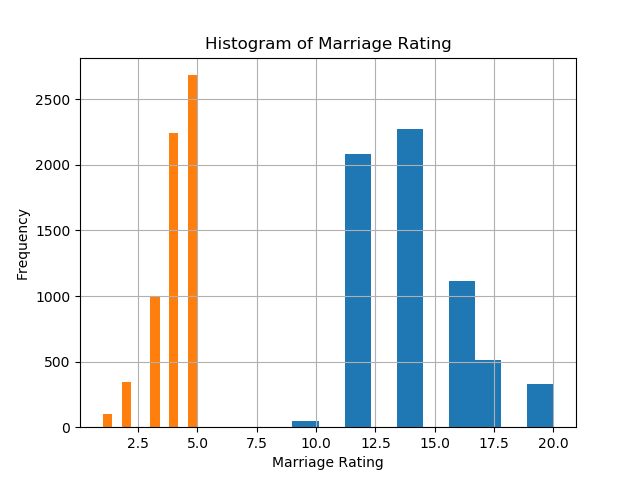

Text(0,0.5,'Frequency')

In [6]:

 #histogram of education
train.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')
train.educ.hist()
plt.title('Histogram of Education')
plt.xlabel('Education Level')
plt.ylabel('Frequency')

In [7]:
# histogram of marriage rating
train.rate_marriage.hist()
plt.title('Histogram of Marriage Rating')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

Text(29.4722,0.5,'Frequency')

<IPython.core.display.Javascript object>


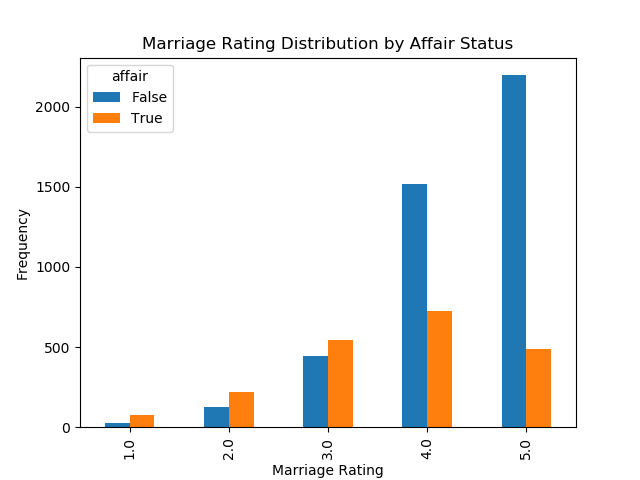

Text(0,0.5,'Frequency')

In [8]:
#Let's take a look at the distribution of marriage ratings for those having affairs versus those not having affairs.
# barplot of marriage rating grouped by affair (True or False)
pd.crosstab(train.rate_marriage, train.affair.astype(bool)).plot(kind='bar')
plt.title('Marriage Rating Distribution by Affair Status')
plt.xlabel('Marriage Rating')
plt.ylabel('Frequency')

<IPython.core.display.Javascript object>


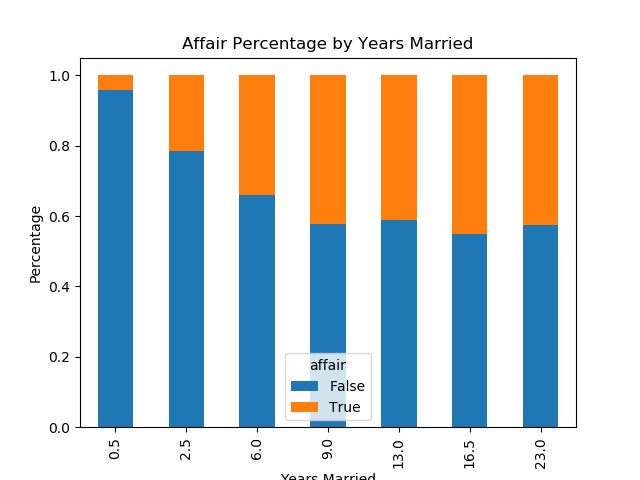

Text(0,0.5,'Percentage')

In [9]:
#Let's use a stacked barplot to look at the percentage of women having affairs by number of years of marriage.

affair_yrs_married = pd.crosstab(train.yrs_married, train.affair.astype(bool))
affair_yrs_married.div(affair_yrs_married.sum(1).astype(float), axis=0).plot(kind='bar', stacked=True)
plt.title('Affair Percentage by Years Married')
plt.xlabel('Years Married')
plt.ylabel('Percentage')


In [10]:
#Prepare Data for Logistic Regression

#To prepare the data, I want to add an intercept column as well as dummy variables for occupation and occupation_husb, since I'm treating them as categorial variables. The dmatrices function from the patsy module can do that using formula language.

train.head()


,rate_marriage,age,yrs_married,children,religious,educ,occupation,occupation_husb,affairs,affair
0,3.0,32.0,9.0,3.0,3.0,17.0,2.0,5.0,0.111111,1
1,3.0,27.0,13.0,3.0,1.0,14.0,3.0,4.0,3.230769,1
2,4.0,22.0,2.5,0.0,1.0,16.0,3.0,5.0,1.400000,1
3,4.0,37.0,16.5,4.0,3.0,16.0,5.0,5.0,0.727273,1
4,5.0,27.0,9.0,1.0,1.0,14.0,3.0,4.0,4.666666,1


In [13]:
y, X = dmatrices('affair ~ rate_marriage + age + yrs_married + children + religious + educ + C(occupation) + C(occupation_husb)', train, return_type="dataframe")
print(X.columns)

Index(['Intercept', 'C(occupation)[T.2.0]', 'C(occupation)[T.3.0]',
       'C(occupation)[T.4.0]', 'C(occupation)[T.5.0]', 'C(occupation)[T.6.0]',
       'C(occupation_husb)[T.2.0]', 'C(occupation_husb)[T.3.0]',
       'C(occupation_husb)[T.4.0]', 'C(occupation_husb)[T.5.0]',
       'C(occupation_husb)[T.6.0]', 'rate_marriage', 'age', 'yrs_married',
       'children', 'religious', 'educ'],
      dtype='object')


In [14]:
#The column names for the dummy variables are ugly, so let's rename those.
# fix column names of X
X = X.rename(columns = {'C(occupation)[T.2.0]':'occ_2',
                        'C(occupation)[T.3.0]':'occ_3',
                        'C(occupation)[T.4.0]':'occ_4',
                        'C(occupation)[T.5.0]':'occ_5',
                        'C(occupation)[T.6.0]':'occ_6',
                        'C(occupation_husb)[T.2.0]':'occ_husb_2',
                        'C(occupation_husb)[T.3.0]':'occ_husb_3',
                        'C(occupation_husb)[T.4.0]':'occ_husb_4',
                        'C(occupation_husb)[T.5.0]':'occ_husb_5',
                        'C(occupation_husb)[T.6.0]':'occ_husb_6'})

In [15]:
#We also need to flatten y into a 1-D array, so that scikit-learn will properly understand it as the response variable.

# flatten y into a 1-D array
y = np.ravel(y)


In [ ]:
Logistic Regression

In [16]:
# instantiate a logistic regression model, and fit with X and y
model = LogisticRegression()
model = model.fit(X, y)

# check the accuracy on the training set
model.score(X, y)

0.7258875274897895

In [18]:
#73% accuracy seems good, but what's the null error rate?

# what percentage had affairs?
y.mean()


0.3224945020420987

In [ ]:
#only 32% of the women had affairs, which means that you could obtain 68% accuracy by always predicting "no". So we're doing better than the null error rate, but not by much.

